# Interpretable Multivariate Forecasting with Deep Learning
## **Exercise**: _Traffic & Construction (Part 1)_
### Workshop for ML Summit — scheduled for April 19th, 2020 2:15 PM CEST
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader), [Serg.ai](https://www.serg.ai/), [Github](https://www.serg.ai/), [Packt](https://www.packtpub.com/authors/serg-masis)) 

This notebook will walk through:

**PART I**

- Data understanding through time-series [autocorrelation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html) and [decomposition](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Also, visually inspecting time series and aggregating and observing daily patterns. 
- Prepare the data
- Load two LSTM models
- Evaluate models using traditional regression metrics, visually observing the predictive error, aggregating the error and evaluating it like classification model.
- Generate and visualize [Integrated Gradient attributions](https://docs.seldon.io/projects/alibi/en/stable/methods/IntegratedGradients.html) for both models.

> ### EXCLUSIVE LIMITED-TIME OFFER
> This notebook demonstrates several of the methods in the book "Interpretable Machine Learning with Python".
> You can get it with a discount on Amazon only for a limited time:
>
> - **Edition**: Printed Edition Only
> - **Start Date**: 8th April 2021
> - **End Date**: 8th May 2021
> - **Discount**: 25%
> - **Code**: 25AIGLOBAL
> - **Link**: https://www.amazon.com/gp/mpc/A3H02EZHXAMXW5

## 1) Install Libraries
#### _(if not installed already)_

Only if not Google Colab because google colab has these preinstalled:

In [ ]:
!pip install --upgrade pandas numpy scikit-learn statsmodels tensorflow Keras matplotlib seaborn

Always installed unless installed already:

In [ ]:
!pip install --upgrade machine-learning-datasets
!pip install --upgrade alibi

## 2) Load Libraries

In [1]:
import math
import os
import warnings
warnings.filterwarnings("ignore")

#DATA WRANGLING
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.data_utils import get_file

#VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

#MODELING
import tensorflow as tf
from tensorflow import keras

#INTERPRETATION
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from alibi.explainers import IntegratedGradients

Using plaidml.keras.backend backend.


Check right version of TF was loaded:

In [2]:
print(tf.__version__)

2.2.1


## 3) Data Understanding

### 3.1) Load Dataset

In [3]:
traffic_df = mldatasets.load("traffic-volume", prepare=True)

https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz downloaded to /Users/smasis/Documents/OTHER/InterpretableMLBook/presentations/ml-summit-2021/data/Metro_Interstate_Traffic_Volume.csv.gz
1 dataset files found in /Users/smasis/Documents/OTHER/InterpretableMLBook/presentations/ml-summit-2021/data folder
parsing /Users/smasis/Documents/OTHER/InterpretableMLBook/presentations/ml-summit-2021/data/Metro_Interstate_Traffic_Volume.csv.gz


### 3.2) Verify Dataset

Should have 25,656 records and 15 columns. None of the columns have nulls, and they are all numeric columns.

In [4]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25656 entries, 2015-10-28 00:00:00 to 2018-09-30 23:00:00
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dow              25656 non-null  int64  
 1   hr               25656 non-null  int64  
 2   temp             25656 non-null  float64
 3   rain_1h          25656 non-null  float64
 4   cloud_coverage   25656 non-null  float64
 5   is_holiday       25656 non-null  int64  
 6   traffic_volume   25656 non-null  float64
 7   weather_Clear    25656 non-null  uint8  
 8   weather_Clouds   25656 non-null  uint8  
 9   weather_Haze     25656 non-null  uint8  
 10  weather_Mist     25656 non-null  uint8  
 11  weather_Other    25656 non-null  uint8  
 12  weather_Rain     25656 non-null  uint8  
 13  weather_Snow     25656 non-null  uint8  
 14  weather_Unknown  25656 non-null  uint8  
dtypes: float64(4), int64(3), uint8(8)
memory usage: 1.8 MB


### 3.3) Compute & Visualize Autocorrelation

Compute autocorrelation function using fast-fourier transform (`fft`) convolution:

In [7]:
autocorr = acf(traffic_df.traffic_volume, unbiased=True,\
               fft=True, alpha=.05, nlags=8736) #adjusted=True
print(autocorr[0].shape)

(8737,)


The highest autocorrelation is in this index:

In [8]:
print(autocorr[0][1:].argmax())

8735


Every how many weeks is this?

In [46]:
8735/168

51.99404761904762

Let's visualize the autocorrelation at several intervals:

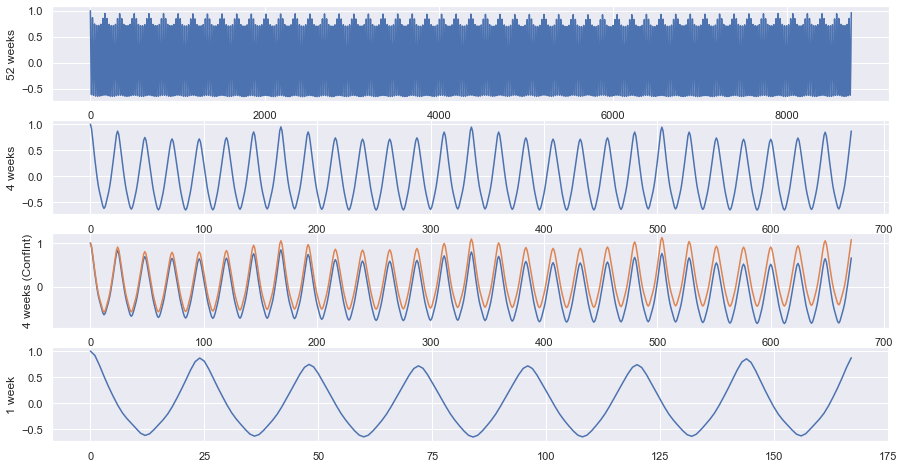

In [9]:
orig_plt_params = plt.rcParams
sns.set()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8))
ax0.plot(np.linspace(0,8736,8737), autocorr[0])
ax0.set_ylabel('52 weeks')
ax1.plot(np.linspace(0,671,672), autocorr[0][:672])
ax1.set_ylabel('4 weeks')
ax2.plot(np.linspace(0,671,672), autocorr[1][:672,:])
ax2.set_ylabel('4 weeks (ConfInt)')
ax3.plot(np.linspace(0,167,168), autocorr[0][:168])
ax3.set_ylabel('1 week')
plt.show()

### 3.4) Visually Inspect Timeseries

#### _(by week)_

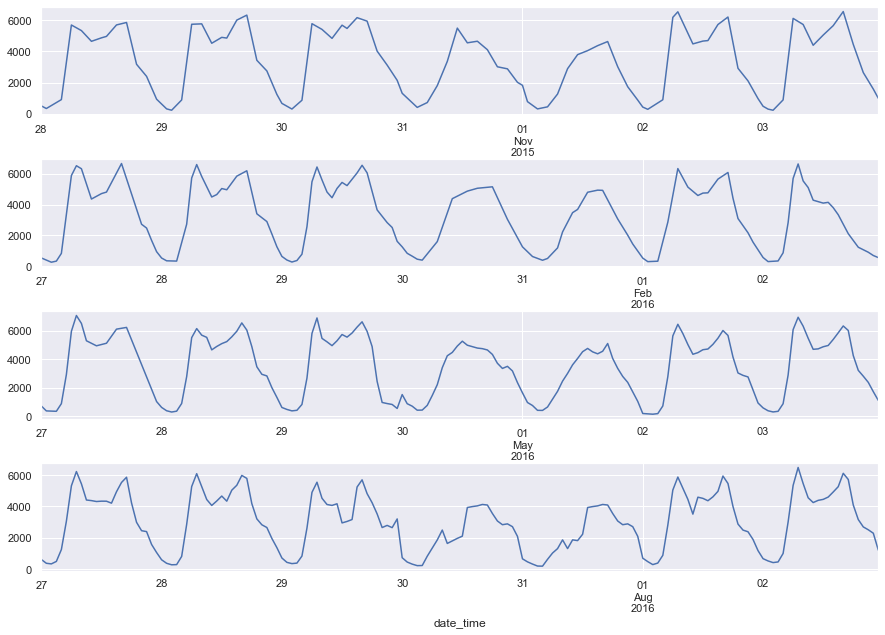

In [10]:
sns.set()
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4)
traffic_df[:168].traffic_volume.plot(ax=ax0)
traffic_df[(168*13):(168*14)].traffic_volume.plot(ax=ax1)
traffic_df[(168*26):(168*27)].traffic_volume.plot(ax=ax2)
traffic_df[(168*39):(168*40)].traffic_volume.plot(ax=ax3)
plt.show()

### 3.5) Time Series Decomposition

<Figure size 864x576 with 0 Axes>

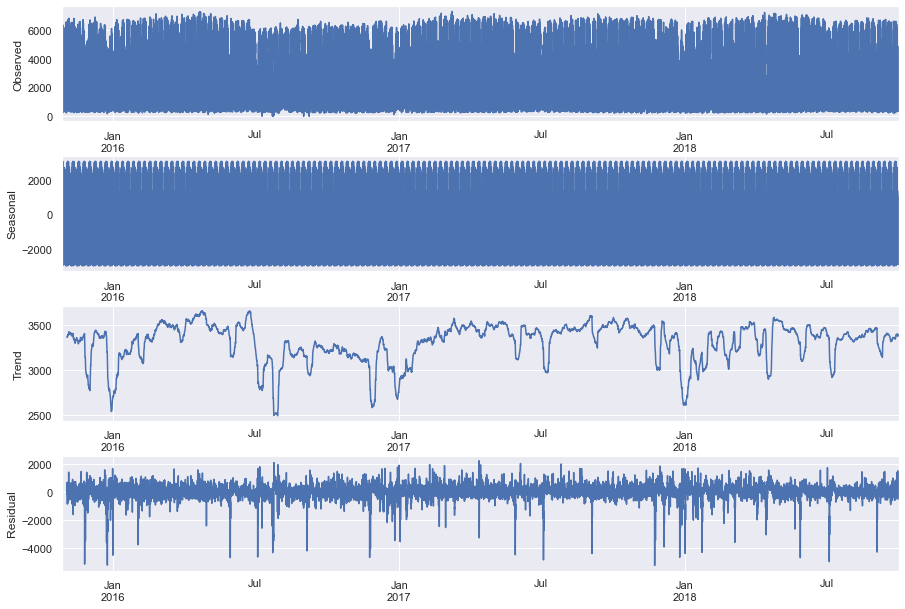

In [16]:
plt.figure(figsize=(12,8))
decomp = seasonal_decompose(traffic_df.traffic_volume,\
                            model='additive', freq=168, 
                            two_sided=False) #period=168

fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3)
decomp.observed.plot(ax=ax0)
ax0.set_ylabel('Observed')
decomp.seasonal.plot(ax=ax1)
ax1.set_ylabel('Seasonal')
decomp.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomp.resid.plot(ax=ax3)
ax3.set_ylabel('Residual')
ax3.set_xlabel('')
plt.show()

### 3.6) Aggregating and Observing Daily Patterns

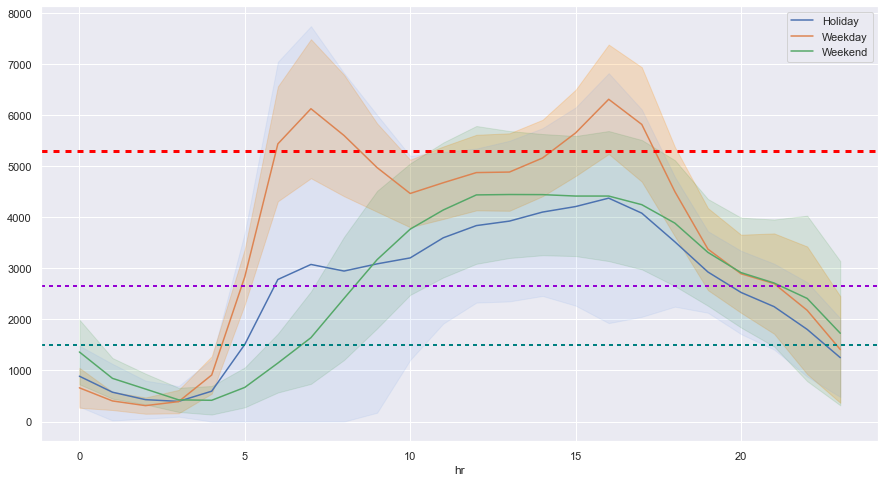

In [17]:
weekend_df = traffic_df[['hr', 'dow', 'is_holiday', 'traffic_volume']].copy()
weekend_df['type_of_day'] = np.where(weekend_df.is_holiday == 1, 'Holiday',
                                   np.where(weekend_df.dow >= 5, 'Weekend', 'Weekday'))
weekend_df = weekend_df.groupby(['type_of_day','hr'])['traffic_volume'].agg(['mean','std']).\
                reset_index().pivot(index='hr', columns='type_of_day', values=['mean', 'std'])
weekend_df.columns = ['_'.join(col).strip().replace('mean_','')\
                      for col in weekend_df.columns.values]
fig, ax = plt.subplots(figsize=(15,8))
weekend_df[['Holiday','Weekday','Weekend']].plot(ax=ax)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Weekday - 2 * weekend_df.std_Weekday, 0),\
                 weekend_df.Weekday + 2 * weekend_df.std_Weekday,
                 color='darkorange', alpha=0.2)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Weekend - 2 * weekend_df.std_Weekend, 0),\
                 weekend_df.Weekend + 2 * weekend_df.std_Weekend,
                 color='green', alpha=0.1)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Holiday - 2 * weekend_df.std_Holiday, 0),\
                 weekend_df.Holiday + 2 * weekend_df.std_Holiday,
                 color='cornflowerblue', alpha=0.1)
ax.axhline(y=5300, linewidth=3, color='red', dashes=(2,2))
ax.axhline(y=2650, linewidth=2, color='darkviolet', dashes=(2,2))
ax.axhline(y=1500, linewidth=2, color='teal', dashes=(2,2))
plt.show()

## 4) Data Preparation

### 4.1) Train / Test / Validation split

Split by train, validation and test:

In [18]:
train = traffic_df[:-4368]
valid = traffic_df[-4368:-2184]
test = traffic_df[-2184:]

Visualize all three:

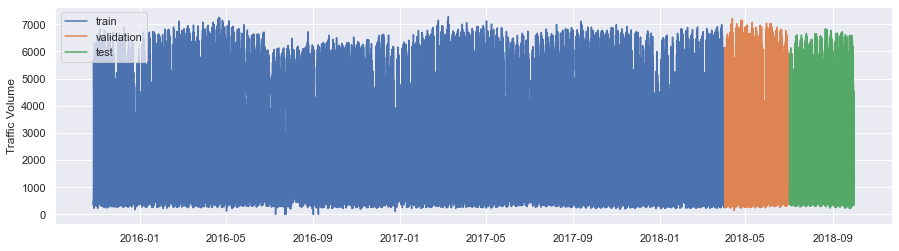

In [19]:
plt.figure(figsize=(15,4))
plt.plot(train.index.values, train.traffic_volume.values,\
         label='train')
plt.plot(valid.index.values, valid.traffic_volume.values,\
         label='validation')
plt.plot(test.index.values, test.traffic_volume.values,\
         label='test')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

### 4.2) Scaling

Initialize scalers:

In [20]:
y_scaler = MinMaxScaler()
y_scaler.fit(traffic_df[['traffic_volume']])
X_scaler = MinMaxScaler()
X_scaler.fit(traffic_df.drop(['traffic_volume'], axis=1))

MinMaxScaler()

Scale train and test:

In [21]:
y_train = y_scaler.transform(train[['traffic_volume']])
X_train = X_scaler.transform(train.drop(['traffic_volume'], axis=1))
y_test = y_scaler.transform(test[['traffic_volume']])
X_test = X_scaler.transform(test.drop(['traffic_volume'], axis=1))

### 4.3) Time Series Generator

Initialize generators for train and test at different lengths:

In [22]:
gen_train_672 = TimeseriesGenerator(X_train, y_train, length=672, batch_size=24)
gen_test_672 = TimeseriesGenerator(X_test, y_test, length=672, batch_size=24)

print("gen_train_672:\t%s\t×\t%s\t→\t%s" % (len(gen_train_672),\
                                    gen_train_672[0][0].shape,\
                                    gen_train_672[0][1].shape))
print("gen_test_672:\t%s\t×\t%s\t→\t%s" % (len(gen_test_672),\
                                   gen_test_672[0][0].shape,\
                                   gen_test_672[0][1].shape))

gen_train_672:	859	×	(24, 672, 14)	→	(24, 1)
gen_test_672:	63	×	(24, 672, 14)	→	(24, 1)


In [23]:
gen_train_168 = TimeseriesGenerator(X_train, y_train, length=168,\
                                    batch_size=24)
gen_test_168 = TimeseriesGenerator(X_test, y_test, length=168,\
                                   batch_size=24)

print("gen_train_168:\t%s\t×\t%s\t→\t%s" % (len(gen_train_168),\
                                    gen_train_168[0][0].shape,\
                                    gen_train_168[0][1].shape))
print("gen_test_168:\t%s\t×\t%s\t→\t%s" % (len(gen_test_168),\
                                   gen_test_168[0][0].shape,\
                                   gen_test_168[0][1].shape))

gen_train_168:	880	×	(24, 168, 14)	→	(24, 1)
gen_test_168:	84	×	(24, 168, 14)	→	(24, 1)


### 4.4) Random Seed

In [24]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

## 5) Load Models

In [25]:
model_path = get_file('LSTM_traffic_672_final.hdf5',\
            'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/LSTM_traffic_672_final.hdf5?raw=true')
lstm_traffic_672_mdl = keras.models.load_model(model_path)
lstm_traffic_672_mdl.summary()

Model: "Traffic_Bidirectional_LSTM_672"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bidir_LSTM (Bidirectional)   (24, 672)                 943488    
_________________________________________________________________
Dropout (Dropout)            (24, 672)                 0         
_________________________________________________________________
Dense (Dense)                (24, 1)                   673       
Total params: 944,161
Trainable params: 944,161
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_path = get_file('LSTM_traffic_168_final.hdf5',\
            'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/LSTM_traffic_168_final.hdf5?raw=true')
lstm_traffic_168_mdl = keras.models.load_model(model_path)
lstm_traffic_168_mdl.summary()

Model: "Traffic_LSTM_168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (24, 168)                 122976    
_________________________________________________________________
Dropout (Dropout)            (24, 168)                 0         
_________________________________________________________________
Dense (Dense)                (24, 1)                   169       
Total params: 123,145
Trainable params: 123,145
Non-trainable params: 0
_________________________________________________________________


## 6) Assessing Time-Series Models with Traditional Interpretation Methods

### 6.1) Using Standard Regression Metrics

Traffic_Bidirectional_LSTM_672
63/63 [==============================] - 21s 327ms/step


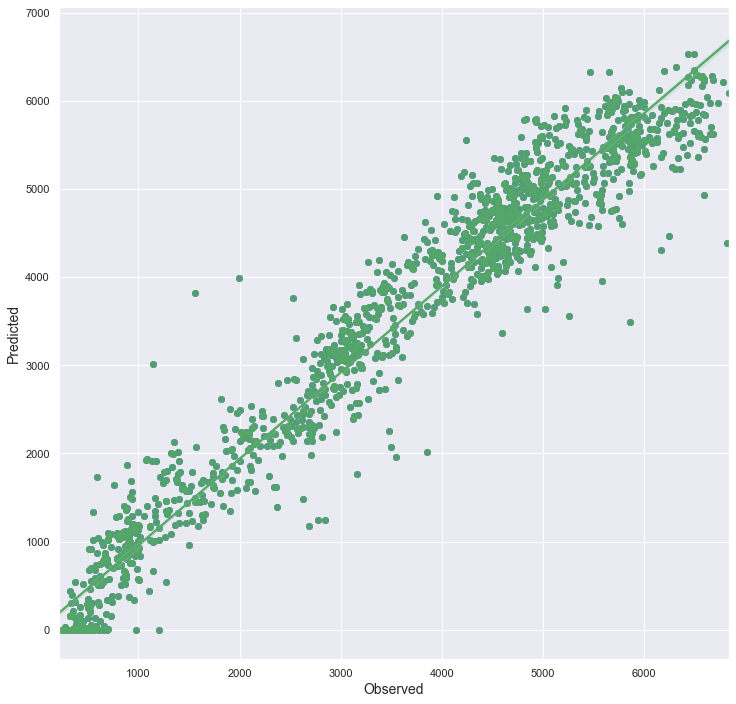

RMSE_train: 537.1589	RMSE_test: 441.2663	r2: 0.9488

Traffic_LSTM_168
84/84 [==============================] - 2s 20ms/step


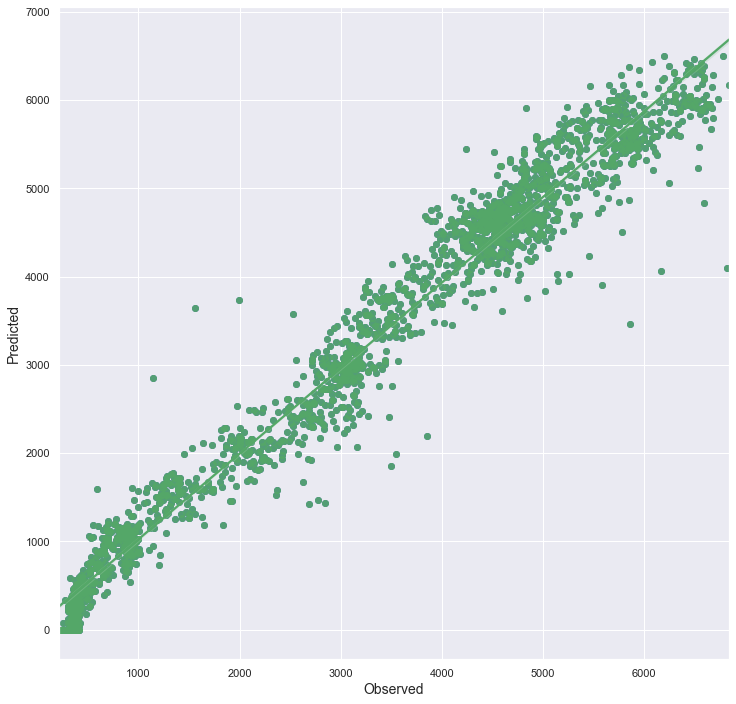

RMSE_train: 473.4279	RMSE_test: 359.0408	r2: 0.9658
CPU times: user 19min 21s, sys: 8min 47s, total: 28min 9s
Wall time: 4min 57s


In [27]:
%%time
print(lstm_traffic_672_mdl.name+"\r\n"+("="*100))
y_train_pred_672, y_test_pred_672, y_train_672, y_test_672 =\
    mldatasets.evaluate_reg_mdl(lstm_traffic_672_mdl, gen_train_672, gen_test_672,\
                             y_train, y_test, scaler=y_scaler, y_truncate=True,\
                             predopts={"verbose":1})

print('\r\n'+lstm_traffic_168_mdl.name+"\r\n"+("="*100))
y_train_pred_168, y_test_pred_168, y_train_168, y_test_168 =\
    mldatasets.evaluate_reg_mdl(lstm_traffic_168_mdl, gen_train_168, gen_test_168,\
                             y_train, y_test, scaler=y_scaler, y_truncate=True,\
                             predopts={"verbose":1})

### 6.2) Visualizing Predictive Error

In [28]:
evaluate_672_df = test.iloc[-y_test_pred_672.shape[0]:,[0,1,5,6]].\
                rename(columns={'traffic_volume':'actual_traffic'})
evaluate_672_df['predicted_traffic'] = y_test_pred_672

evaluate_168_df = test.iloc[-y_test_pred_168.shape[0]:,[0,1,5,6]].\
                rename(columns={'traffic_volume':'actual_traffic'})
evaluate_168_df['predicted_traffic'] = y_test_pred_168

In [29]:
evaluate_672_df

,dow,hr,is_holiday,actual_traffic,predicted_traffic
date_time,,,,,
2018-07-30 00:00:00,0,0,0,640.0,998.761108
2018-07-30 01:00:00,0,1,0,384.0,64.304565
2018-07-30 02:00:00,0,2,0,317.0,0.000000
2018-07-30 03:00:00,0,3,0,333.0,298.437378
2018-07-30 04:00:00,0,4,0,915.0,1508.385254
...,...,...,...,...,...
2018-09-30 19:00:00,6,19,0,3543.0,3202.212646
2018-09-30 20:00:00,6,20,0,2781.0,2687.730713
2018-09-30 21:00:00,6,21,0,2159.0,2144.519287


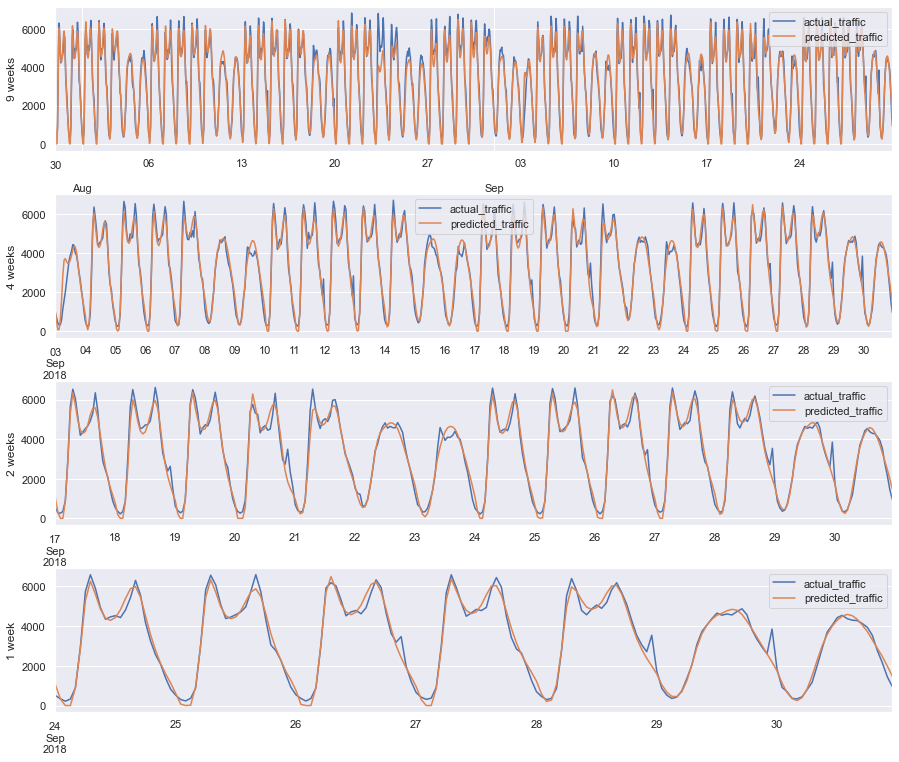

In [31]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,10))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3)
evaluate_168_df.iloc[-1512:,[3,4]].plot(ax=ax0)
ax0.set_ylabel('9 weeks')
evaluate_168_df.iloc[-672:,[3,4]].plot(ax=ax1)
ax1.set_ylabel('4 weeks')
evaluate_168_df.iloc[-336:,[3,4]].plot(ax=ax2)
ax2.set_ylabel('2 weeks')
evaluate_168_df.iloc[-168:,[3,4]].plot(ax=ax3)
ax3.set_ylabel('1 week')
ax3.set_xlabel('')
plt.show()

### 6.3) Predictive Error Aggregations

In [32]:
evaluate_168_df['type_of_day'] = np.where(evaluate_168_df.is_holiday == 1, 'Holiday',
                                   np.where(evaluate_168_df.dow >= 5, 'Weekend', 'Weekday'))
evaluate_168_df.drop(['dow','is_holiday'], axis=1, inplace=True)

evaluate_672_df['type_of_day'] = np.where(evaluate_672_df.is_holiday == 1, 'Holiday',
                                   np.where(evaluate_672_df.dow >= 5, 'Weekend', 'Weekday'))
evaluate_672_df.drop(['dow','is_holiday'], axis=1, inplace=True)

In [33]:
evaluate_672_df

,hr,actual_traffic,predicted_traffic,type_of_day
date_time,,,,
2018-07-30 00:00:00,0,640.0,998.761108,Weekday
2018-07-30 01:00:00,1,384.0,64.304565,Weekday
2018-07-30 02:00:00,2,317.0,0.000000,Weekday
2018-07-30 03:00:00,3,333.0,298.437378,Weekday
2018-07-30 04:00:00,4,915.0,1508.385254,Weekday
...,...,...,...,...
2018-09-30 19:00:00,19,3543.0,3202.212646,Weekend
2018-09-30 20:00:00,20,2781.0,2687.730713,Weekend
2018-09-30 21:00:00,21,2159.0,2144.519287,Weekend


In [34]:
def rmse(g):
    rmse = np.sqrt(metrics.\
                   mean_squared_error(g['actual_traffic'],\
                                      g['predicted_traffic']))
    return pd.Series({'rmse': rmse})

evaluate_by_hr_672_df = evaluate_672_df.\
                        groupby(['type_of_day', 'hr']).apply(rmse).reset_index().\
                        pivot(index='hr', columns='type_of_day', values='rmse')
evaluate_by_hr_168_df = evaluate_168_df.\
                        groupby(['type_of_day', 'hr']).apply(rmse).reset_index().\
                        pivot(index='hr', columns='type_of_day', values='rmse')
mean_by_daytype_672_s = evaluate_by_hr_672_df.mean(axis=0)
mean_by_daytype_168_s = evaluate_by_hr_168_df.mean(axis=0)

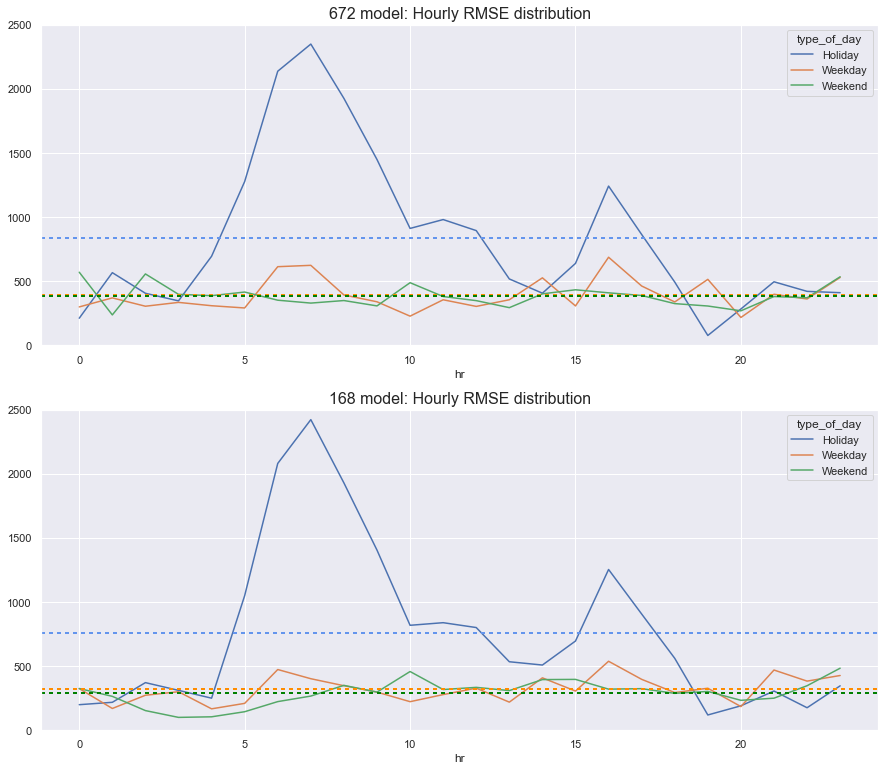

In [35]:
fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(15,10))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2)

evaluate_by_hr_672_df.plot(ax=ax0)
ax0.set_title('672 model: Hourly RMSE distribution', fontsize=16)
ax0.set_ylim([0,2500])
ax0.axhline(y=mean_by_daytype_672_s.Holiday, linewidth=2,\
            color='cornflowerblue', dashes=(2,2))
ax0.axhline(y=mean_by_daytype_672_s.Weekday, linewidth=2,\
            color='darkorange', dashes=(2,2))
ax0.axhline(y=mean_by_daytype_672_s.Weekend, linewidth=2,\
            color='green', dashes=(2,2))

evaluate_by_hr_168_df.plot(ax=ax1)
ax1.set_title('168 model: Hourly RMSE distribution', fontsize=16)
ax1.set_ylim([0,2500])
ax1.axhline(y=mean_by_daytype_168_s.Holiday, linewidth=2,\
           color='cornflowerblue', dashes=(2,2))
ax1.axhline(y=mean_by_daytype_168_s.Weekday, linewidth=2,\
           color='darkorange', dashes=(2,2))
ax1.axhline(y=mean_by_daytype_168_s.Weekend, linewidth=2,\
           color='green', dashes=(2,2))
plt.show()

### 6.4) Evaluating It Like A Classification Problem

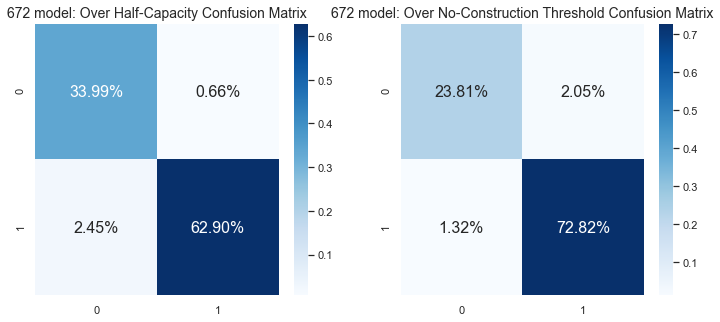

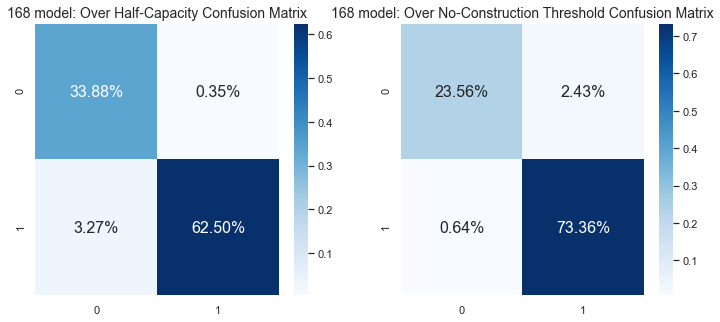

In [36]:
evaluate_dfs = [evaluate_672_df, evaluate_168_df]
lookbacks = [672, 168]

for e in range(2):
    evaluate_df = evaluate_dfs[e]
    lb = lookbacks[e]

    actual_over_half_cap = np.where(evaluate_df['actual_traffic'] >\
                                    2650, 1, 0)
    pred_over_half_cap = np.where(evaluate_df['predicted_traffic'] >\
                                  2650, 1, 0)
    actual_over_nc_thresh = np.where(evaluate_df['actual_traffic'] >\
                                    1500, 1, 0)
    pred_over_nc_thresh = np.where(evaluate_df['predicted_traffic'] >\
                                  1500, 1, 0)

    mldatasets.\
        compare_confusion_matrices(actual_over_half_cap, pred_over_half_cap,\
                                   actual_over_nc_thresh, pred_over_nc_thresh,\
                                   str(lb)+' model: Over Half-Capacity',\
                                   str(lb)+' model: Over No-Construction Threshold')

## 7) Generating LSTM Attributions with Integrated Gradients

### 7.1) Create Generator for Entire Datasets (both models)

In [37]:
y_all = y_scaler.transform(traffic_df[['traffic_volume']])
X_all = X_scaler.transform(traffic_df.drop(['traffic_volume'], axis=1))
gen_all_672 = TimeseriesGenerator(X_all, y_all, length=672, batch_size=24)
gen_all_168 = TimeseriesGenerator(X_all, y_all, length=168, batch_size=24)
print("gen_all_678:\t%s\t×\t%s\t→\t%s" % (len(gen_all_672),\
                                    gen_all_672[0][0].shape,\
                                    gen_all_672[0][1].shape))
print("gen_all_168:\t%s\t×\t%s\t→\t%s" % (len(gen_all_168),\
                                    gen_all_168[0][0].shape,\
                                    gen_all_168[0][1].shape))

gen_all_678:	1041	×	(24, 672, 14)	→	(24, 1)
gen_all_168:	1062	×	(24, 168, 14)	→	(24, 1)


### 7.2) Define Instances of Interest

Integrated gradients is a local interpretation method. so let's get a few sample "instances of interest" we can interpret. We know holidays are a concern, so let's see if our models pick up on the importance of is_holiday for one example (`holiday_afternoon_s`). Also, mornings are a concern, especially mornings with a larger than average rush hour because of weather conditions, so we have one example for that (`peak_morning_s`). Lastly, a hot day might have more traffic, especially on a weekend (`hot_saturday_s`):

In [38]:
X_df = traffic_df.drop(['traffic_volume'], axis=1).reset_index(drop=True)

holiday_afternoon_s = X_df[(X_df.index >= 23471) & (X_df.dow==0) &\
                           (X_df.hr==16) & (X_df.is_holiday==1)]
peak_morning_s = X_df[(X_df.index >= 23471) & (X_df.dow==2) &\
                      (X_df.hr==8) & (X_df.weather_Clouds==1) &\
                      (X_df.temp<20)]
hot_saturday_s = X_df[(X_df.index >= 23471) & (X_df.dow==5) &\
                      (X_df.hr==12) & (X_df.temp>29)]

### 7.3) Initialize Integrated Gradients

Integrated gradients (IG), also known as Path-Integrated Gradients, can be apply it to any neural network architecture because it computes the gradients of the output with respect to the inputs averaged all along a path
between a baseline and the actual input. However, it requires the definition of a baseline, which is supposed to convey a lack of signal, like a uniformly colored image. Also, although the name suggests the use of path integrals, integrals aren't computed but approximated, with summation in sufficiently small intervals for a certain number of steps. It then feeds these variations to the CNN, computes the gradients for each one, and averages them. The IG is the dot product of the image times the gradient averages.

IG is grounded in solid mathematical theory. In this case, it's the Fundamental Theorem of Calculus for Line Integrals. The mathematical proof ensures that attributions add up. In other words, the attributions produced by IG sum to the difference between the prediction between that of the input and of the baseline. In addition to this property, which they call completeness, there is linearity preservation, symmetry preservation, and sensitivity. We won't describe each of these properties here. However, it's important to note that some interpretation methods satisfy notable mathematical properties, while others demonstrate their effectiveness in practical terms.

IntegratedGradients from the alibi package only requires a deep learning model, but it is recommended to set a number of steps (`n_steps`) for the integral approximation and `internal_batch_size`. We will instantiate one explainer for each model:

In [39]:
%%time
ig_672  = IntegratedGradients(lstm_traffic_672_mdl,\
                        n_steps=25, internal_batch_size=24)
ig_168  = IntegratedGradients(lstm_traffic_168_mdl,\
                        n_steps=25, internal_batch_size=24)

### 7.4) Compute and Visualize Attributions

Let's look at one instance of interest:

In [45]:
holiday_afternoon_s

,dow,hr,temp,rain_1h,cloud_coverage,is_holiday,weather_Clear,weather_Clouds,weather_Haze,weather_Mist,weather_Other,weather_Rain,weather_Snow,weather_Unknown
25000,0,16,23.61,0.25,90.0,1,0,0,0,0,0,1,0,0


It's index once we remove the lookback:

In [44]:
nidx = holiday_afternoon_s.index.tolist()[0] - 672
print(nidx)

24328


Shape of the batch that it's in:

In [40]:
batch_X = gen_all_672[nidx//24][0]
print(batch_X.shape)

(24, 672, 14)


Define samples and initialized integrated gradients to iterate:

In [ ]:
samples = [holiday_afternoon_s, peak_morning_s]
sample_names = ['Holiday Afternoon', 'Peak Morning']
igs = [ig_672, ig_168]
lbs = [672, 168]

Iterate and produce attribution maps:

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


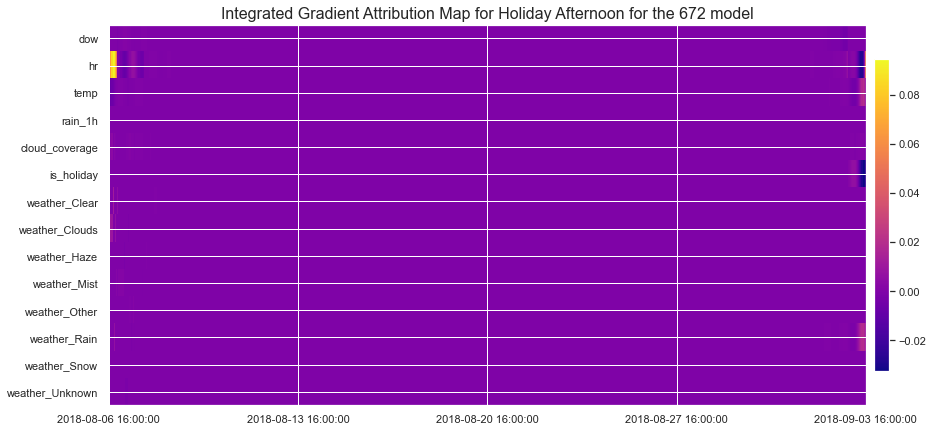

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


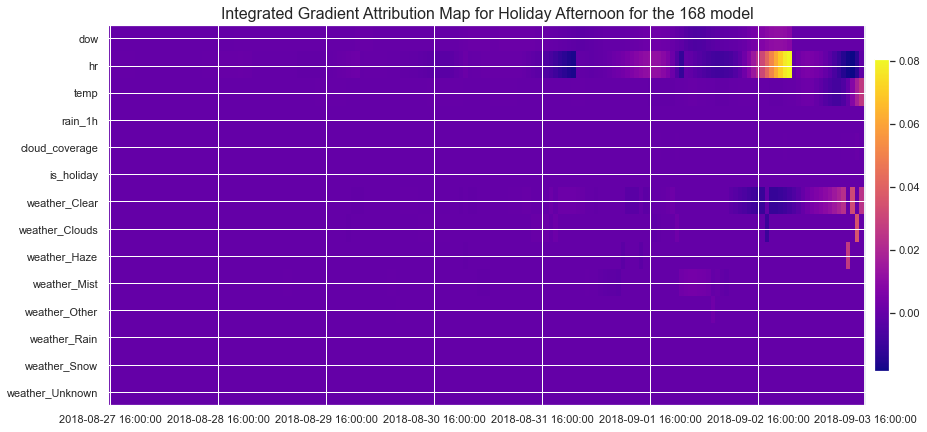

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


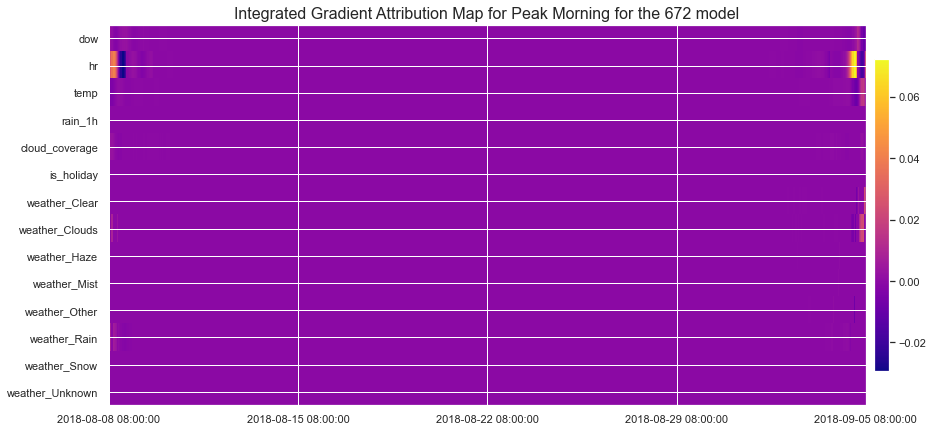

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


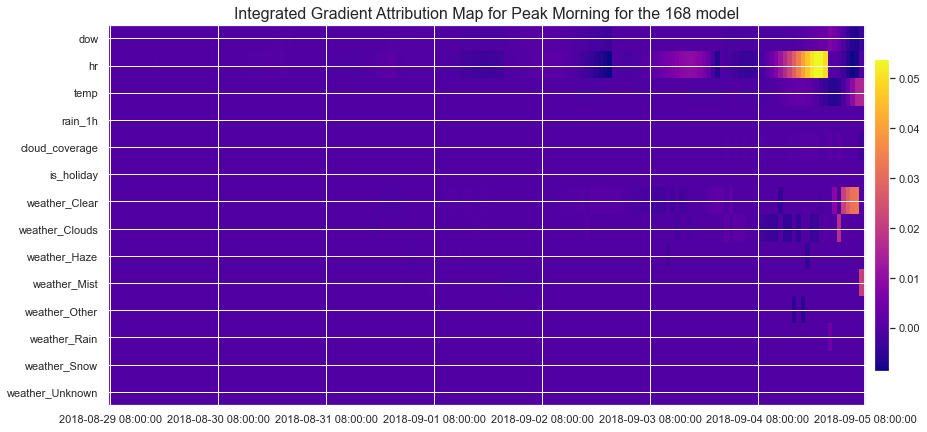

CPU times: user 7min, sys: 1min 4s, total: 8min 4s
Wall time: 2min 48s


In [42]:
%%time
for s in range(len(samples)):
    for i in range(len(igs)):
        
        nidx = samples[s].index.tolist()[0] - lb
        lb = lbs[i]
        if lb == 672:
            batch_X = gen_all_672[nidx//24][0]
            p = 5 #Create 5 tick marks...
            f = '7D' #seperated by 1 week periods
        else:
            batch_X = gen_all_168[nidx//24][0]
            p = 8 #Create 8 tick marks...
            f = '1D' #seperated by 1 day periods
            
        explanation = igs[i].explain(batch_X, target=None)
        attributions = explanation.attributions
        if isinstance(attributions, (list, tuple)) and len(attributions)==1:
            attributions = attributions[0]
        attribution_img = np.transpose(attributions[nidx%24,:,:])
        
        end_date = traffic_df.iloc[samples[s].index].\
                                index.to_pydatetime()[0]
        date_range = pd.date_range(end=end_date, periods=p,\
                            freq=f).to_pydatetime().tolist()
        columns = samples[s].columns.tolist()
        
        plt.figure(figsize=(14,7))
        plt.title('Integrated Gradient Attribution Map for {} for the {} model'.\
                  format(sample_names[s], lb), fontsize=16)
        plt.imshow(attribution_img, interpolation='nearest',\
                                           aspect='auto', cmap='plasma')
        plt.xticks(np.linspace(0,lb,p).astype(int), labels=date_range)
        plt.yticks([*range(14)], labels=columns)
        plt.colorbar(pad=0.01,fraction=0.02,anchor=(1.0,0.0))
        plt.show()